In [1]:
# A simple notebook demonstrating how to extract an attention map from DinoV2 inference (with registers) 

# Most of the core code was originally published here:
#  https://gitlab.com/ziegleto-machine-learning/dino/-/tree/main/

# November 11th, 2023 by Lance Legel (lance@3co.ai) from 3co, Inc. (https://3co.ai)

%load_ext autoreload
%autoreload 2

In [2]:
import os
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import warnings
warnings.filterwarnings('ignore', category=UserWarning)
from torchvision import datasets, transforms
import numpy as np
from PIL import Image
from dinov2.models.vision_transformer import vit_small, vit_base, vit_large
from matplotlib.colors import Normalize
from io import BytesIO
import requests

In [3]:
# These are settings for ensuring input images to DinoV2 are properly sized

class ResizeAndPad:
    def __init__(self, target_size, multiple):
        self.target_size = target_size
        self.multiple = multiple

    def __call__(self, img):
        # Resize the image
        img = transforms.Resize(self.target_size)(img)

        # Calculate padding
        pad_width = (self.multiple - img.width % self.multiple) % self.multiple
        pad_height = (self.multiple - img.height % self.multiple) % self.multiple

        # Apply padding
        img = transforms.Pad((pad_width // 2, pad_height // 2, pad_width - pad_width // 2, pad_height - pad_height // 2))(img)
        
        return img

image_dimension = 952
    
# This is what DinoV2 sees
target_size = (image_dimension, image_dimension)

# During inference / testing / deployment, we want to remove data augmentations from the input transform:
data_transforms = transforms.Compose([ ResizeAndPad(target_size, 14),
                                       transforms.CenterCrop(image_dimension),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
                                     ]
                                     )

In [4]:
image_size = (image_dimension, image_dimension)
output_dir = '.'
patch_size = 14
n_register_tokens = 4

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

model = vit_base(
        patch_size=14,
        img_size=526,
        init_values=1.0,
        num_register_tokens=n_register_tokens,
        block_chunks=0
)

model.load_state_dict(torch.load('dinov2_vitb14_reg4_pretrain.pth'))
for p in model.parameters():
    p.requires_grad = False
model.to(device)
model.eval()

/tmp/ipykernel_45461/907002352.py:16: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('dinov2_vitb14_reg4_pretrain.pth'))


DinoVisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 768, kernel_size=(14, 14), stride=(14, 14))
    (norm): Identity()
  )
  (blocks): ModuleList(
    (0-11): 12 x NestedTensorBlock(
      (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (attn): MemEffAttention(
        (qkv): Linear(in_features=768, out_features=2304, bias=True)
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=768, out_features=768, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (ls1): LayerScale()
      (drop_path1): Identity()
      (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=768, out_features=3072, bias=True)
        (act): GELU(approximate='none')
        (fc2): Linear(in_features=3072, out_features=768, bias=True)
        (drop): Dropout(p=0.0, inplace=False)
      )
      (ls2): LayerScale()
      (drop_path2): Identity()
    )
  )
  (n

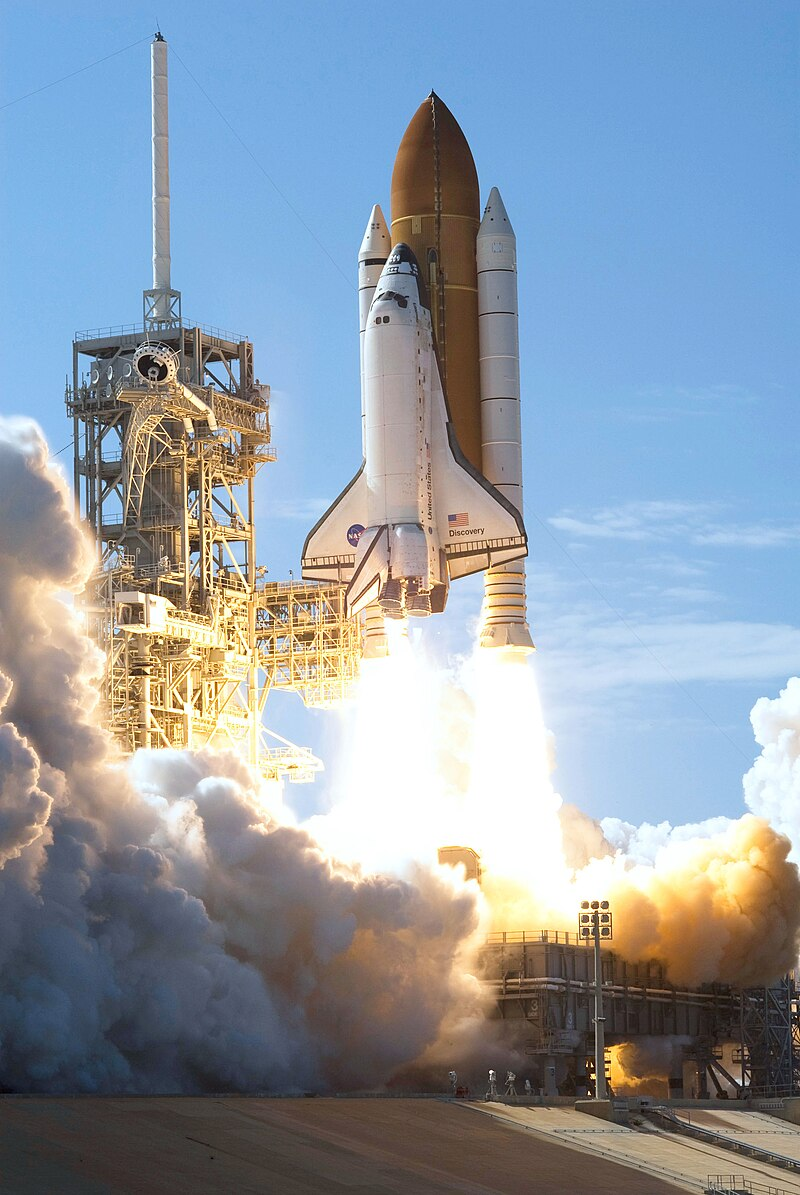

In [5]:
# URL of the image
image_url = "https://upload.wikimedia.org/wikipedia/commons/thumb/c/cd/STS-124_launch_from_a_distance.jpg/800px-STS-124_launch_from_a_distance.jpg"  # Replace with your image URL

# Download the image
response = requests.get(image_url)

# Check if the request was successful
if response.status_code == 200:
    # Open the image
    original_image = Image.open(BytesIO(response.content))

    # Display the image
    display(original_image)
else:
    print(f"Failed to download the image. Status code: {response.status_code}")

(original_w, original_h) = original_image.size

img = data_transforms(original_image)

# make the image divisible by the patch size
w, h = img.shape[1] - img.shape[1] % patch_size, img.shape[2] - img.shape[2] % patch_size
img = img[:, :w, :h]

w_featmap = img.shape[-2] // patch_size
h_featmap = img.shape[-1] // patch_size

img = img.unsqueeze(0)
img = img.to(device)

In [6]:
attention = model.get_last_self_attention(img.to(device))

In [7]:
print("Attention {}: {}".format(attention.shape, attention))

Attention torch.Size([1, 12, 4629, 4629]): tensor([[[[1.4474e-05, 1.9053e-03, 3.6321e-03,  ..., 3.1162e-05,
           2.4813e-05, 2.5423e-05],
          [1.2614e-04, 4.3418e-03, 1.6300e-02,  ..., 7.0276e-05,
           1.6114e-04, 1.1011e-04],
          [3.1358e-05, 8.8969e-04, 2.2244e-03,  ..., 5.9549e-05,
           5.4722e-05, 4.2212e-05],
          ...,
          [2.6705e-04, 2.2982e-03, 5.7707e-02,  ..., 7.5753e-03,
           7.3574e-04, 2.9955e-04],
          [1.3326e-04, 4.1264e-03, 3.2078e-02,  ..., 1.2108e-03,
           7.9861e-04, 6.6029e-04],
          [2.4534e-04, 3.6191e-03, 4.2717e-02,  ..., 2.8825e-04,
           5.5032e-04, 6.1915e-04]],

         [[2.9087e-05, 3.4735e-03, 8.9949e-03,  ..., 6.6183e-04,
           3.9006e-04, 2.1560e-04],
          [3.3342e-04, 5.7911e-03, 1.4739e-02,  ..., 8.5928e-04,
           8.2686e-04, 5.4904e-04],
          [8.3019e-05, 3.0286e-03, 5.9363e-03,  ..., 1.0456e-03,
           6.9607e-04, 3.8884e-04],
          ...,
          [1.573

In [8]:
number_of_heads = attention.shape[1]

# attention tokens are packed in after the first token; the spatial tokens follow
attention = attention[0, :, 0, 1 + n_register_tokens:].reshape(number_of_heads, -1)

In [9]:
print(attention.shape)

torch.Size([12, 4624])


In [10]:
# resolution of attention from transformer tokens
attention = attention.reshape(number_of_heads, w_featmap, h_featmap)
print(attention.shape)

torch.Size([12, 68, 68])


In [11]:
# upscale to higher resolution closer to original image
attention = nn.functional.interpolate(attention.unsqueeze(0), scale_factor=patch_size, mode = "nearest")[0].cpu()
print(attention.shape)

torch.Size([12, 952, 952])


In [12]:
# sum all attention across the 12 different heads, to get one map of attention across entire image
attention = torch.sum(attention, dim=0)
print(attention.shape)

torch.Size([952, 952])


In [13]:
# interpolate attention map back into original image dimensions
attention_of_image = nn.functional.interpolate(attention.unsqueeze(0).unsqueeze(0), size=(original_h, original_w), mode='bilinear', align_corners=False)
attention_of_image = attention_of_image.squeeze()
print(attention_of_image.shape)

torch.Size([1195, 800])


In [14]:
# Normalize image_metric to the range [0, 1]
image_metric = attention_of_image.numpy()
normalized_metric = Normalize(vmin=image_metric.min(), vmax=image_metric.max())(image_metric)

# Apply the Reds colormap
reds = plt.cm.Reds(normalized_metric)

# Create the alpha channel
alpha_max_value = 1.00  # Set your max alpha value

# Adjust this value as needed to enhance lower values visibility
gamma = 0.5  

# Apply gamma transformation to enhance lower values
enhanced_metric = np.power(normalized_metric, gamma)

# Create the alpha channel with enhanced visibility for lower values
alpha_channel = enhanced_metric * alpha_max_value

# Add the alpha channel to the RGB data
rgba_mask = np.zeros((image_metric.shape[0], image_metric.shape[1], 4))
rgba_mask[..., :3] = reds[..., :3]  # RGB
rgba_mask[..., 3] = alpha_channel  # Alpha

# Convert the numpy array to PIL Image
rgba_image = Image.fromarray((rgba_mask * 255).astype(np.uint8))

# Save the image
rgba_image.save('attention_mask.png')

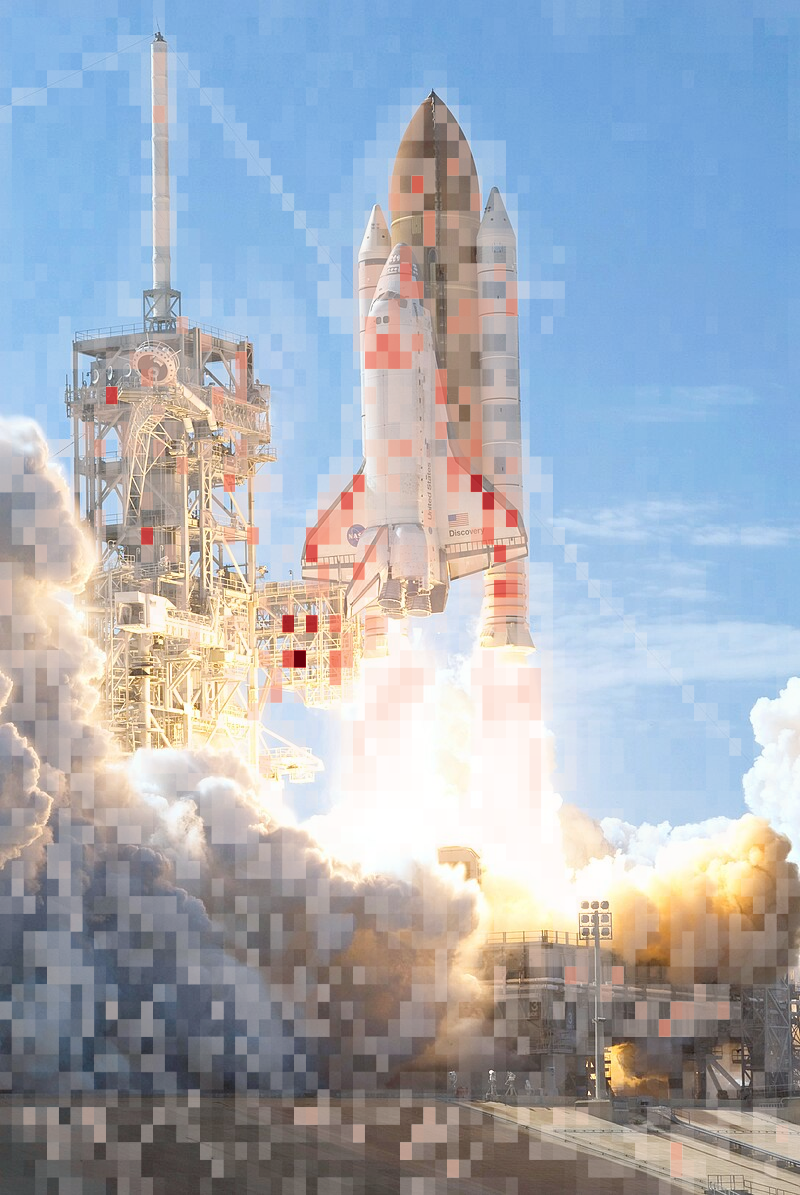

In [15]:
# Load the attention mask with PIL
attention_mask_image = Image.open("{}/attention_mask.png".format(output_dir))

# Ensure both images are in the same mode
if original_image.mode != 'RGBA':
    original_image = original_image.convert('RGBA')

# Overlay the second image onto the first image
# The second image must be the same size as the first image
original_image.paste(attention_mask_image, (0, 0), attention_mask_image)

# Save or show the combined image
original_image.save('image_with_attention.png')

# Or display it
display(original_image)